In [1]:
# !pip install lifelines

In [3]:
""" Step 1: Import python libraries """

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter 
from lifelines.plotting import add_at_risk_counts

sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")


In [4]:
""" Step 2: Load data """

file1 = pd.read_csv('Data\clinical_data.csv')
file2 = pd.read_csv('Data\FS_Q3.csv')

In [5]:
# Quick view of data
file1.head()

,bcr_patient_barcode,OS.time,age_at_initial_pathologic_diagnosis,initial_pathologic_dx_year,race,ajcc_pathologic_tumor_stage,histological_type,menopause_status,vital_status,tumor_status,margin_status
0,TCGA-3C-AAAU,4047,55,2004,3,11,2,3,0,1,1
1,TCGA-3C-AALI,4005,50,2003,2,5,1,2,0,0,1
2,TCGA-3C-AALJ,1474,62,2011,2,5,1,2,0,0,1
3,TCGA-3C-AALK,1448,52,2011,2,1,1,4,0,0,0
4,TCGA-4H-AAAK,348,50,2013,3,7,2,2,0,0,1


In [6]:
file2.head(3)

,C2_8,C2_14,C2_17,C2_18,C2_21,C2_24,C2_26,C2_27,C2_29,C2_36,...,C2_12993,C2_12999,C2_13000,C2_13002,C2_13011,C2_13012,C2_13013,C2_13014,C2_13015,bcr_patient_barcode
0,1000.000000,0.0,186.575285,813.424716,0.0,-44.925175,899.865003,1044.925175,0.0,-899.865003,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,TCGA-S9-A7J2
1,79.141165,0.0,689.889744,310.110256,0.0,-392.931833,1120.790711,392.931833,0.0,-1120.790711,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,TCGA-C8-A1HL
2,1000.000000,0.0,0.000000,1000.000000,0.0,-215.273161,935.599090,215.273161,0.0,-935.599090,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,TCGA-EW-A2FS


In [7]:
""" Step 3: Preprocess & Integrate data"""

file1 = file1.rename(columns={ 'vital_status':'OS.Status'})
data = pd.merge(file1[['bcr_patient_barcode','OS.time','OS.Status']],file2, how="inner", on=['bcr_patient_barcode'])

In [8]:
# Check missing values
data.isna().sum().sum()

0

In [9]:
data.head()

,bcr_patient_barcode,OS.time,OS.Status,C2_8,C2_14,C2_17,C2_18,C2_21,C2_24,C2_26,...,C2_12985,C2_12993,C2_12999,C2_13000,C2_13002,C2_13011,C2_13012,C2_13013,C2_13014,C2_13015
0,TCGA-3C-AAAU,4047,0,239.944247,0.0,275.216808,271.506060,0.0,-146.325123,1104.262777,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,TCGA-3C-AALI,4005,0,874.459013,0.0,156.236037,-112.860806,0.0,-194.454580,1160.097435,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,TCGA-3C-AALJ,1474,0,876.939826,0.0,73.680588,926.319412,0.0,188.688429,1099.624481,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,TCGA-3C-AALK,1448,0,945.216242,0.0,17.790732,982.209268,0.0,-104.671852,1091.422468,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,TCGA-4H-AAAK,348,0,365.669368,0.0,364.275663,635.724337,0.0,-80.992388,1001.332779,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [10]:
data['OS.time'].describe()

count    1078.000000
mean     1248.950835
std      1196.290526
min         0.000000
25%       451.750000
50%       848.000000
75%      1682.750000
max      8605.000000
Name: OS.time, dtype: float64

In [12]:
# Prepare data for ML modesl
# Split train and test set 
drop_list = ['bcr_patient_barcode', 'OS.time', 'Risk', 'OS.Status']

X_train1, X_test1 = train_test_split(data, test_size=0.2,
                                     stratify=data['OS.Status'],
                                    random_state=5,
                                    shuffle=True)

# Get median of X_train and assign Risk variable
med_train= X_train1['OS.time'].median()
print('Median value of OS.time in training set', med_train)
X_train1['Risk'] = np.where(X_train1['OS.time'] >= med_train, 0, 1)
X_test1['Risk'] = np.where(X_test1['OS.time'] >= med_train, 0, 1)


X_train = X_train1.drop(drop_list, axis = 1)
X_test = X_test1.drop(drop_list, axis = 1)

y_train = X_train1['Risk'].values
y_test = X_test1['Risk'].values

print(X_train.shape)
print(X_test.shape)

# print("Number of death in train set : {}".format(sum(X_train1['OS.Status']==1)))
# print("Number of alive in train set : {}".format(sum(X_train1['OS.Status']==0)))
# print("Number of death in test set : {}".format(sum(X_test1['OS.Status']==1)))
# print("Number of alive in test set : {}".format(sum(X_test1['OS.Status']==0)))

print(X_test1[['Risk', 'OS.Status']].groupby('Risk').sum())


Median value of OS.time in training set 849.5
(862, 3271)
(216, 3271)
      OS.Status
Risk           
0            19
1            11


In [15]:
# Normalise data
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)


In [16]:
X_test.head()

,C2_8,C2_14,C2_17,C2_18,C2_21,C2_24,C2_26,C2_27,C2_29,C2_36,...,C2_12985,C2_12993,C2_12999,C2_13000,C2_13002,C2_13011,C2_13012,C2_13013,C2_13014,C2_13015
0,0.636010,-0.362102,-0.727616,0.787989,-0.445968,-0.330882,0.180709,-0.006949,-0.402424,-0.212502,...,-0.281356,0.198776,-0.243717,-0.267194,-0.233839,-0.445968,-0.445968,-0.445968,-0.445968,-0.445968
1,0.507660,-0.362102,-0.680268,0.765407,-0.445968,0.805695,0.285419,0.877310,-0.402424,-0.307400,...,-0.281356,0.198776,-0.243717,-0.267194,-0.233839,-0.445968,-0.445968,-0.445968,-0.445968,-0.445968
2,-0.234077,-0.362102,-0.334230,-0.705615,-0.445968,-0.673861,0.178225,0.382317,-0.402424,-0.210250,...,-0.281356,0.198776,-0.243717,-0.267194,-0.233839,-0.445968,-0.445968,-0.445968,-0.445968,-0.445968
3,0.688312,-0.362102,-0.040642,0.460348,-0.445968,0.020835,0.534986,-0.406133,-0.402424,-0.533581,...,-0.281356,0.198776,-0.243717,-0.267194,-0.233839,-0.445968,-0.445968,-0.445968,-0.445968,-0.445968
4,0.688312,-0.362102,0.430036,-0.215552,-0.445968,0.186372,0.210762,-0.594010,-0.402424,-0.239739,...,-0.281356,0.198776,-0.243717,-0.267194,-0.233839,-0.445968,-0.445968,-0.445968,-0.445968,-0.445968


In [17]:
""" Step 4: Train and evaluate Algorithms"""

# Design ML model - Set up
RANDOM_STATE = 12

# Define ML algorithms
classifiers = {
    "SVM": SVC(random_state=RANDOM_STATE),
    "KNearest": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest Classifier": RandomForestClassifier(random_state=RANDOM_STATE),
    "Gradient Boost Classifier": GradientBoostingClassifier(random_state=RANDOM_STATE)
}


In [18]:
import time
# For reference, before applying Gridsearch CV to find best parameter
def cross_validate(X_train, y_train, cv=5):
    for key, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=cv)
        print("Classifiers: ", classifier.__class__.__name__, 
              "has a training accuracy score of", round(training_score.mean(),2) * 100, "%")


# Use GridSearchCV to find the best parameters:
def model_best_estimator(x_train, y_train, RANDOM_STATE=12, cv=5):
    
    # SVC 
    t0 = time.time()
    SVC_grid = {"kernel": ["rbf", "linear", "sigmoid", 'poly'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    grid_log_reg = GridSearchCV(SVC(random_state=RANDOM_STATE, max_iter=10000),
                                SVC_grid, cv=cv, n_jobs=-1)
    grid_log_reg.fit(x_train, y_train)

    # get the SVC with the best parameters.
    svc_model = grid_log_reg.best_estimator_
    t1 = time.time()

    print("Best fit parameter for SVC", svc_model)
    print("Elapsed time {:.2f} s".format(t1 - t0))

    
    # KNN
    t2 = time.time()
    knears_params_grid = {"n_neighbors": list(range(3,50,1)), 
                          "metric": ('minkowski', 'euclidean')}
    
    grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params_grid, cv=cv)
    grid_knears.fit(x_train, y_train)
   
    # KNN best estimator
    knn = grid_knears.best_estimator_
    t3 = time.time()
    print("\nBest fit parameter for KNN", knn)
    print("Effective metric:", knn.effective_metric_)
    print("Elapsed time {:.2f} s".format(t3 - t2))
    
    # Naive Bayes
    t10 = time.time()
    nb_params_grid = {'var_smoothing': [1e-9, 0.01, 0.1, 1]}
    
    grid_nb = GridSearchCV(GaussianNB(), nb_params_grid, cv=cv)
    grid_nb.fit(x_train, y_train)
   
    # NB best estimator
    nb = grid_nb.best_estimator_
    t11 = time.time()
    print("\nBest fit parameter for NB", nb)
    print("Elapsed time {:.2f} s".format(t11 - t10))


    # DecisionTree Classifier:
    t4 = time.time()
    tree_params_grid = {"criterion": ["gini", "entropy"], "max_depth": list(range(3,10,1)),
                        "min_samples_leaf": [4,8,15,30,50]}
    grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                             tree_params_grid, cv=cv)
    grid_tree.fit(x_train, y_train)
    
    # tree best estimator
    tree_clf = grid_tree.best_estimator_
    t5 = time.time()
    
    print("\nBest fit parameter for Decision Tree:", tree_clf)
    print("Elapsed time {:.2f} s".format(t5 - t4))

    # Random Forest Classifier
    t6 = time.time()
    rf_params_grid = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,10,1)), 
                "min_samples_leaf": [4,8,15,30],  "n_estimators":[500]}

    grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), 
                           rf_params_grid, cv=cv)
    grid_rf.fit(x_train, y_train)

    # random forest best estimator
    rf = grid_rf.best_estimator_
    t7 = time.time()

    print("\nBest fit parameter for Random Forest:", rf)
    print("Elapsed time {:.2f} s".format(t7 - t6))


    # GBoost Classifier
    t8 = time.time()
    gb_para = {'learning_rate': [0.01, 0.1, 1], "n_estimators":[500] }

    grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE), 
                           gb_para, cv=cv)
    grid_gb.fit(x_train, y_train)

    # GB best estimator
    gb = grid_gb.best_estimator_
    t9 = time.time()

    print("\nBest fit parameter for Random Forest:", gb)
    print("Elapsed time {:.2f} s".format(t9 - t8))
    
    
    return [svc_model, knn, nb, tree_clf, rf, gb]   


# Evaluate model by using cross validation
def evaluate_model(classifier, x_train, y_train, cv=5):
    classifier.fit(x_train, y_train)
    score = cross_val_score(classifier, x_train, y_train, cv=cv)
    return score

# Get training model results
def train_model(classifier, x_train, y_train, cv=5):
    y_train_pre = cross_val_predict(classifier, x_train, y_train, cv=cv)
    print(classification_report(y_train, y_train_pre, labels=[1,0]))  
  

# Get testing model results
def predict_model(classifier, x_test, y_test):
    y_pre = classifier.predict(x_test)
    print(classification_report(y_test, y_pre, labels=[1,0]))
    
    # Confusion Matrix
    print('Confusion matrix:', classifier)
    cf_matrix = confusion_matrix(y_test, y_pre, labels=[1,0])
    ax =sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['High Risk', 'Low Risk'],
                yticklabels=['High Risk', 'Low Risk'])
    ax.set(xlabel="Predicted outputs", ylabel = "Actual outputs")
    plt.show()
  
    return y_pre

In [19]:
# Set up function for training and testing flow
# Start with find the best parameter for ML model, train and get result + visualisation results

def train_test(X_train, y_train, X_test, y_test, RANDOM_STATE=RANDOM_STATE, cv=5):
    # Find best parameter for model
    model_select_result = model_best_estimator(X_train, y_train)
    
    log_reg, knn, nb, tree_clf, rf, gb = model_select_result
    
    results =[]
    # Train and get result
    for classifier in model_select_result:
        print("\nPredict model:", classifier)
        evaluate_model(classifier, X_train, y_train, cv=cv)
        print("\nTraining result:")
        train_model(classifier, X_train, y_train, cv=cv)
        print("Testing result:")
        y_pre = predict_model(classifier, X_test, y_test)
        results.append(y_pre)
    
    
    #can add feature importance
    return [log_reg, knn, nb, tree_clf, rf, gb, results]


************* Evaluate models **************
Initial evaluate training model
Classifiers:  SVC has a training accuracy score of 56.00000000000001 %
Classifiers:  KNeighborsClassifier has a training accuracy score of 54.0 %
Classifiers:  GaussianNB has a training accuracy score of 50.0 %
Classifiers:  DecisionTreeClassifier has a training accuracy score of 55.00000000000001 %
Classifiers:  RandomForestClassifier has a training accuracy score of 53.0 %
Classifiers:  GradientBoostingClassifier has a training accuracy score of 55.00000000000001 %
Best fit parameter for SVC SVC(C=100, kernel='poly', max_iter=10000, random_state=12)
Elapsed time 62.69 s

Best fit parameter for KNN KNeighborsClassifier(n_neighbors=12)
Effective metric: euclidean
Elapsed time 29.98 s

Best fit parameter for NB GaussianNB()
Elapsed time 2.20 s

Best fit parameter for Decision Tree: DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=50,
                       random_state=12)
Elapsed time

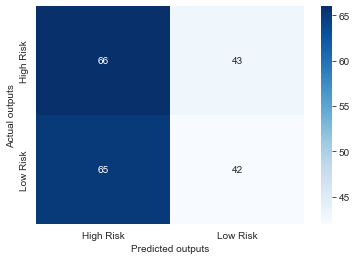


Predict model: KNeighborsClassifier(n_neighbors=12)

Training result:
              precision    recall  f1-score   support

           1       0.56      0.62      0.59       431
           0       0.57      0.51      0.54       431

    accuracy                           0.56       862
   macro avg       0.57      0.56      0.56       862
weighted avg       0.57      0.56      0.56       862

Testing result:
              precision    recall  f1-score   support

           1       0.54      0.60      0.57       109
           0       0.54      0.49      0.51       107

    accuracy                           0.54       216
   macro avg       0.54      0.54      0.54       216
weighted avg       0.54      0.54      0.54       216

Confusion matrix: KNeighborsClassifier(n_neighbors=12)


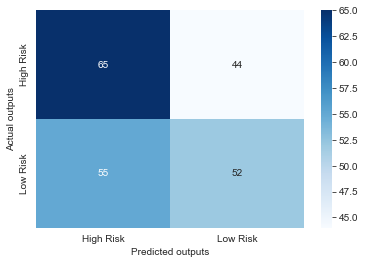


Predict model: GaussianNB()

Training result:
              precision    recall  f1-score   support

           1       0.50      0.71      0.59       431
           0       0.50      0.29      0.37       431

    accuracy                           0.50       862
   macro avg       0.50      0.50      0.48       862
weighted avg       0.50      0.50      0.48       862

Testing result:
              precision    recall  f1-score   support

           1       0.54      0.87      0.67       109
           0       0.65      0.24      0.35       107

    accuracy                           0.56       216
   macro avg       0.59      0.56      0.51       216
weighted avg       0.59      0.56      0.51       216

Confusion matrix: GaussianNB()


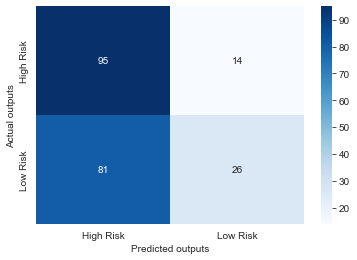


Predict model: DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=50,
                       random_state=12)

Training result:
              precision    recall  f1-score   support

           1       0.56      0.59      0.57       431
           0       0.56      0.53      0.55       431

    accuracy                           0.56       862
   macro avg       0.56      0.56      0.56       862
weighted avg       0.56      0.56      0.56       862

Testing result:
              precision    recall  f1-score   support

           1       0.52      0.51      0.52       109
           0       0.51      0.51      0.51       107

    accuracy                           0.51       216
   macro avg       0.51      0.51      0.51       216
weighted avg       0.51      0.51      0.51       216

Confusion matrix: DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=50,
                       random_state=12)


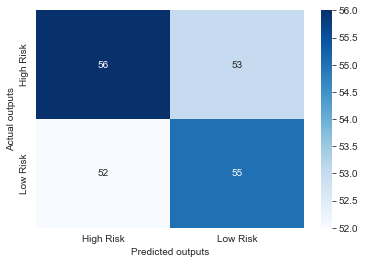


Predict model: RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=8,
                       n_estimators=500, random_state=12)

Training result:
              precision    recall  f1-score   support

           1       0.57      0.58      0.57       431
           0       0.57      0.56      0.57       431

    accuracy                           0.57       862
   macro avg       0.57      0.57      0.57       862
weighted avg       0.57      0.57      0.57       862

Testing result:
              precision    recall  f1-score   support

           1       0.57      0.50      0.53       109
           0       0.55      0.61      0.58       107

    accuracy                           0.56       216
   macro avg       0.56      0.56      0.55       216
weighted avg       0.56      0.56      0.55       216

Confusion matrix: RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=8,
                       n_estimators=500, random_state=12)


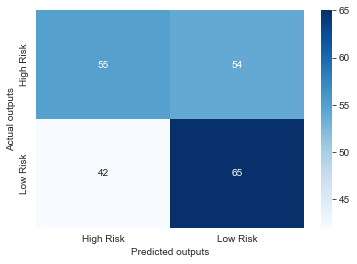


Predict model: GradientBoostingClassifier(n_estimators=500, random_state=12)

Training result:
              precision    recall  f1-score   support

           1       0.56      0.53      0.55       431
           0       0.56      0.59      0.57       431

    accuracy                           0.56       862
   macro avg       0.56      0.56      0.56       862
weighted avg       0.56      0.56      0.56       862

Testing result:
              precision    recall  f1-score   support

           1       0.53      0.58      0.55       109
           0       0.53      0.48      0.50       107

    accuracy                           0.53       216
   macro avg       0.53      0.53      0.53       216
weighted avg       0.53      0.53      0.53       216

Confusion matrix: GradientBoostingClassifier(n_estimators=500, random_state=12)


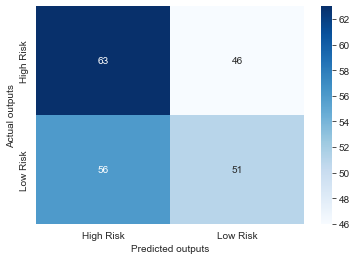

In [20]:
### Evaluate models

# Train model
print("\n************* Evaluate models **************")

# Intial evaluate train model with 5 fold cross-validation
print("Initial evaluate training model")
cross_validate(X_train, y_train)

# Improve model, avoid overfitting and find optimal hyperparameter by applying GridSearchCV
# Evaluate model and get result
svc_model, knn, nb, tree_clf, rf, gb, results = train_test(X_train, y_train, X_test, y_test)

After delete 0 in time (213, 3)
70% Top value for LR 1317.1, 30% bottom for LR 534.6
(86, 3)

Model SVM


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          45.98 <0.005     36.28

After delete 0 in time (213, 3)
70% Top value for LR 1387.2999999999995, 30% bottom for LR 519.0
(85, 3)

Model KNearest


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          21.83 <0.005     18.35

After delete 0 in time (213, 3)
70% Top value for LR 1753.9999999999998, 30% bottom for LR 503.7
(85, 3)

Model Naive Bayes


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.68 <0.005      9.85

After delete 0 in time (213, 3)
70% Top value for LR 1245.1, 30% bottom for LR 521.2
(86, 3)

Model DecisionTreeClassifier


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          16.28 <0.005     14.16

After delete 0 in time (213, 3)
70% Top value for LR 1559.1, 30% bottom for LR 466.0
(85, 3)

Model Random Forest Classifier


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          27.30 <0.005     22.45

After delete 0 in time (213, 3)
70% Top value for LR 1381.5999999999997, 30% bottom for LR 530.0
(84, 3)

Model Gradient Boost Classifier


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.54 <0.005     15.88

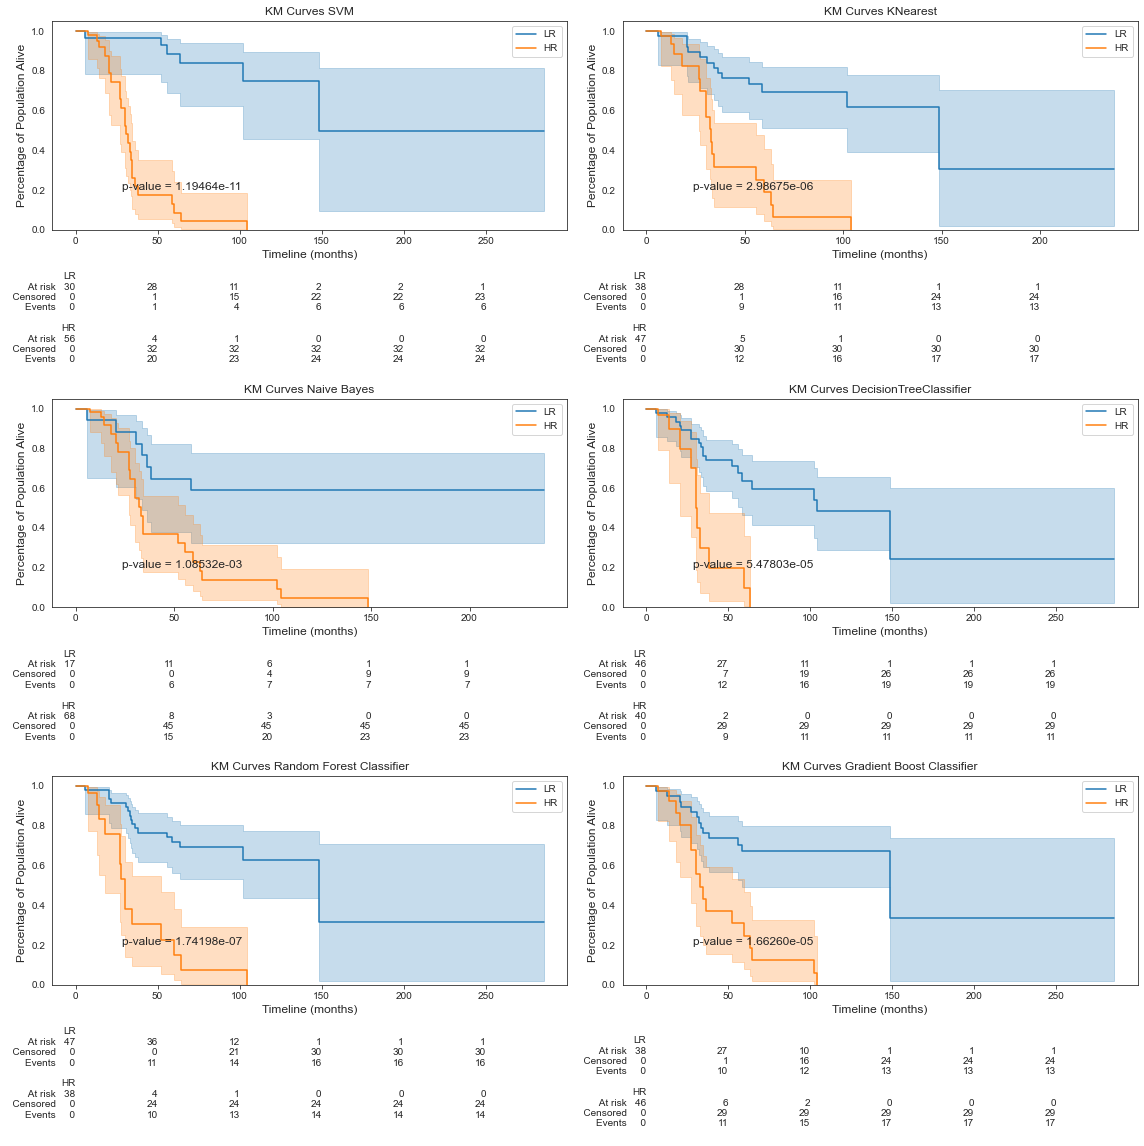

In [23]:
""" Step 5: Risk visualisation"""
# Plot Kaplan Meier curves and log rank test
names = list(classifiers.keys())
k=0
fig, ax = plt.subplots(2,3, figsize=(16,16))
for i in range(0,6):
    dfs = X_test1[['OS.time','OS.Status']].reset_index(drop=True)
    y_pred = results[i]
    dfs['Risk'] = y_pred

     # Eliminate the OS.time =0
    dfs = dfs.query('`OS.time` != 0')
    print('After delete 0 in time',dfs.shape)

    # Filter event
    e1 = dfs.query('`OS.Status` ==1')
    e0 = dfs.query('`OS.Status` ==0')

    # Filter 30% top and bot of time for the OS.status =0
    top = np.quantile(e0.query('Risk ==0')['OS.time'],0.7)
    bot = np.quantile(e0.query('Risk ==1')['OS.time'],0.3)

    print(f'70% Top value for LR {top}, 30% bottom for LR {bot}')
    lr = e0.query('Risk ==0 & `OS.time` >= @top') 
    hr = e0.query('Risk==1 & `OS.time` < @bot') 
    new_df = pd.concat([lr, hr, e1])

    # Time to month
    new_df['OS.time'] =new_df['OS.time']/30
    print(new_df.shape)
    # dfs.to_csv("predict{}.csv".format(names[i]), index=False)
    ix = new_df['Risk'] == 1

    T_hr, E_hr = new_df.loc[ix]['OS.time'], new_df.loc[ix]['OS.Status']
    T_lr, E_lr = new_df.loc[~ix]['OS.time'], new_df.loc[~ix]['OS.Status']

    # Set-up plots
    k +=1
    plt.subplot(3,2,k)

    # Fit survival curves
    
    kmf_exp = KaplanMeierFitter()
    ax = kmf_exp.fit(T_lr, E_lr, label='LR').plot_survival_function()
    
    kmf_control = KaplanMeierFitter()
    ax = kmf_control.fit(T_hr, E_hr, label='HR').plot_survival_function()

    

    add_at_risk_counts(kmf_exp, kmf_control)
    # Format graph
    plt.ylim(0,1.05)
    ax.set_xlabel('Timeline (months)',fontsize='large')
    ax.set_ylabel('Percentage of Population Alive',fontsize='large')

    # Calculate p-value
    # res = logrank_test(T_hr, T_lr, alpha=.95)
    res = logrank_test(T_hr, T_lr, event_observed_A=E_hr, event_observed_B=E_lr, alpha=.95)
    print('\nModel', names[i])
    res.print_summary()
   

    # Location the label at the 1st out of 9 tick marks
    xloc = max(np.max(T_hr),np.max(T_lr)) / 10
    ax.text(xloc,.2,'p-value = {:.5e}'.format(res.p_value),fontsize=12)
    ax.set_title('KM Curves {}' .format(names[i]))
    plt.tight_layout()
    

In [24]:
""" Step 6: SHAP plot"""
# Interpret data
# # # Initialize JS For Plot
import shap
shap.initjs()

model_list = svc_model, knn, nb, tree_clf, rf, gb
for i in range(0,6):
    print('\nModel', names[i])
    m = model_list[i]
    m.fit(X_train,y_train)
    explainer = shap.Explainer(m.predict, X_train, feature_names=X_train.columns)
    shaps = explainer(X_test)
    shap.summary_plot(shaps, X_test)

In [26]:
# DT
shap.initjs()
tree_clf.fit(X_train,y_train)
explainer = shap.TreeExplainer(tree_clf, X_train, feature_names=X_train.columns)

shaps = explainer.shap_values(X_test)
shap.summary_plot(shaps[1], X_test, show=True)
